# Imports

In [75]:
# help here: 
#  - https://www.youtube.com/watch?v=nNvPvvuPnGs 
#  - https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb

import os
import time
import math
import warnings
from IPython.display import clear_output, HTML

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint
import requests

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim

# Configuration

In [76]:
PREVIEW_REVIEW_SIZE = 1000
CHUNK_SIZE = 10000
EXTRACT_PARQUET = False
PREPROCESS_IMAGES = False
EXTRACT_CNN_FEATURES = False
REQUEST_YELP = False

# SAMPLING
SAMPLING_REVIEW_SIZE = 1000
SAMPLING_PHOTOS_SIZE = 100

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
ORIGINAL_PHOTOS_DIR = 'data/original/yelp_photos/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
WORK_PHOTOS_DIR = 'data/work/yelp_photos/'

PREFIX_YELP = 'yelp_academic_dataset_'

YELP_CLIENT_ID = '9YdHyRH4uodO_PVLWQisUA'
YELP_API_KEY = '7n-jw4kngIfHFPULb9NXfFt0iy0RliPO1ksKqJOykdPVbWU6uSipZld_LPm0CKuto3nmmMLZ6U8vvlrG7J8Lbbe_NTbgpVD4MZXmLBozFALZPaKeoZRemAg1Ph9JZXYx'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=matplotlib.MatplotlibDeprecationWarning)

sns.set()
pandarallel.initialize(progress_bar=True, verbose=False)

# Trick for jupyter lab with pyLdaVis
css_str = """<style> 
    .jp-Button path { fill: var(--jp-inverse-layout-color3);}
    .lm-TabBar-tabIcon path { fill: var(--jp-inverse-layout-color3);}
    .jp-icon-warn0 path {fill: var(--jp-inverse-layout-color3);}
    .bp3-button-text path {    fill: var(--jp-inverse-layout-color3);}
    .jp-icon-brand0 path { fill: var(--jp-inverse-layout-color3);}
    text.terms { fill: var(--jp-inverse-layout-color3);}
</style>"""  
display(HTML(css_str))

# Extractions des sujets des reviews

In [77]:
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Nom du fichier', 'Taille du fichier']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_REVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df   

def printHtmlH(text, level):
    display(HTML(f'<h{level} style="text-decoration:underline">{text}</h{level}'))

def printHtmlList(items_list, tag='ul'):
    html_list = f'<{tag}>'
    for item in items_list:
        html_list = html_list + f'<li>{item}</li>'
    html_list = html_list + f'</{tag}>'
    display(HTML(html_list))

## Prévisualiastions des datasets

In [78]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Nom du fichier                       Taille du fichier
-----------------------------------  -------------------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [79]:
preview_dfs = {}
for name in files:
    printHtmlH(f'Prévualisation du DataSet: "{name}"', '4')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

business_id                           name  \
740  Tuzyf8Z-R_i661AeJAc9QQ                   Indigo Point   
66   n7AQvGvNHlmun3kqXeBKVQ        Roy's Appliance Service   
206  IYlUaKC9nICjiWdk-ShPlg                     Bub's Cafe   
419  REuCtUZ2MeehpDipAKBSmQ                  Lens Crafters   
394  z9wCTHYI2VZy9YIblwSsgg  The Silo Eatery Coffee Bakery   

                        address      city state postal_code   latitude  \
740  1850 Providence Lakes Blvd   Brandon    FL       33511  27.911256   
66                               Meridian    ID       83646  43.643494   
206               220 2nd St SW    Carmel    IN       46032  39.976614   
419         2416 W Brandon Blvd   Brandon    FL       33511  27.940411   
394  9036 Brittany Way, Bldg 18     Tampa    FL       33619  27.946496   

      longitude  stars  review_count  is_open  \
740  -82.315876    2.0             5        1   
66  -116.436000    5.0             5        1   
206  -86.130124    4.0           175        0   
419  -82.321746    4.0             6        1   
394  -82.355563    4.0             5        0   

                                            attributes  \
740                     {'ByAppointmentOnly': 'False'}   
66              {'BusinessAcceptsCreditCards': 'True'}   
206  {'RestaurantsReservations': 'False', 'Business...   
419  {'BusinessAcceptsCreditCards': 'True', 'Busine...   
394  {'RestaurantsDelivery': 'False', 'Ambience': '...   

                                            categories  \
740             Apartments, Home Services, Real Estate   
66                 Local Services, Appliances & Repair   
206                    Restaurants, Breakfast & Brunch   
419  Eyewear & Opticians, Shopping, Health & Medica...   
394   Coffee & Tea, Restaurants, Food, Cafes, Bakeries   

                                                 hours  
740  {'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ...  
66   {'Monday': '0:0-0:0', 'Tuesday': '8:30-15:0', ...  
206  {'Monday': '7:0-14:0', 'Tuesday': '7:0-14:0', ...  
419  {'Monday': '9:0-17:30', 'Tuesday': '9:0-17:30'...  
394                                               None

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

business_id                                               date
316  -8QRV-C80eFO6m058-PK4A  2011-03-26 16:25:13, 2011-07-26 16:03:05, 2012...
605  -HPQAylabtzueY4Hxm2NSA           2015-05-22 18:12:07, 2017-04-08 17:27:02
185  -4HTX6yWNuRJusCTezaUnQ  2013-05-24 21:02:55, 2013-05-26 18:03:52, 2013...
981  -THauPUGjEYdwUAne95wWg  2010-03-30 16:02:52, 2010-09-25 23:05:14, 2010...
38   -02xFuruu85XmDn2xiynJw  2012-01-17 00:27:09, 2012-01-26 23:24:22, 2012...

business_id    object
date           object
dtype: object

review_id                 user_id             business_id  \
280  t3SWA33VyH353uoE6UAe2g  E2CuwvUZdhvrAvvNdmmN8A  eS4billU3Yd9hoVUFfZFbA   
195  c9uUji8cUjVqkMisIfHjyg  zMeM0HTnNfjBffhgm-3EBA  dBCNUSbz5-8nQNrxWo5deg   
786  _1CdSipAK1mysZXfSf2gOA  yBHMWksiTkRNjmMEW5t9Mg  2zocwC7qMq3LsivPn9Z-Eg   
947  lu5_R05VXvKpHCIH_bPolw  Q8t6yZx8N6jea41GYwlIQw  8gV3YUl8uqHnA-wZ3UZ5Dg   
737  nAx6LHi2qcvh1Rg9MaqckA  s_tmMM7ZV6LyRosVL0UyhA  jxfAi7UDmtbhyPw7ZsfKVw   

     stars  useful  funny  cool  \
280      2       1      1     0   
195      4       0      0     0   
786      5       1      0     0   
947      4       0      0     0   
737      3       0      0     0   

                                                  text                date  
280  I love Skyline Chili.  I first had this stuff ... 2012-12-04 03:39:49  
195  I love this place.  The food is great and the ... 2011-05-27 17:36:12  
786  I love this shoppe. I have been here a few tim... 2013-03-18 20:11:28  
947  The food is amazing! Fried pickles and the sma... 2017-10-24 20:39:17  
737  The food is really good!! The service is less ... 2018-08-04 20:20:55

review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object

user_id             business_id  \
62   BDOCu_rbF75vMK0stzxqkg  RiB0e4L-Gx3BJ5qlsa1ZIw   
780  I9Qscn-UTiYF0fjnsUw4kQ  j1LGyDLjesniwqc1rHpctA   
499  ikWD8meznb14w9yNie3bwQ  xKmfYXFFpoWcWcmABxmpuw   
420  G2Fz49ZmyGAp6Zu9tFdVXg  8NyDM-FDoWEEeEG9XUwnbg   
141  q4hQSVOCK-FfNfqPqiBh4g  aM3gFY8Eq2KJuvNBlGPJEA   

                                                  text                date  \
62   Great market! Beautiful location and easy park... 2017-10-01 14:42:06   
780  Worst service I've ever encountered at a Westi... 2013-08-18 00:45:38   
499  Back for the second time today to visit my tot... 2012-01-10 22:41:40   
420                                   No tips required 2010-01-30 16:17:48   
141  Get a free tote for checking in with Yelp @ th... 2013-08-26 00:29:42   

     compliment_count  
62                  0  
780                 0  
499                 0  
420                 0  
141                 0

user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object

user_id     name  review_count        yelping_since  \
608  UKSw9kfoBfdatSMUl-jGnA        E           495  2006-03-12 17:04:39   
181  q-kq52Hm8a5ajWJ_dUlOoA    Minji             2  2010-07-16 15:37:15   
722  NbwxzbxcTzx9KjOroh37VA      jen           196  2006-01-04 20:13:43   
928  GcEaEhVBp0DcAbgdPw41eg  Randall            65  2009-02-22 01:11:23   
539  zkamNMEjihh3zN7lC7_WVw  Matthew            15  2006-02-04 15:53:46   

     useful  funny  cool                                         elite  \
608    2018    684  1233  2006,2007,2008,2009,2010,2011,2012,2013,2014   
181       8      1     2                                                 
722     252    105   195                           2006,2007,2009,2010   
928      81     27    17                                                 
539      35      4    22                                                 

                                               friends  fans  ...  \
608  XWqgD3Z8VS-s-ubgMrCW1w, KRNOnUV_2adeNIYreN1Iaw...   285  ...   
181  3iYVBhusw8WzL-fpHfzSJg, AHYWPHP0A_liXRQ1vwOTOQ...     0  ...   
722  CUjwFvpy5R2Hjgf02Nd_Bw, bgRoSGcm0mlJwBzucS3V7w...    36  ...   
928  QJr0eqQOtIgPfXM8BH3vqQ, jEAETZgxa8XsYCXtt6-e2g...     2  ...   
539  YLzb3jjc3p-XAOBRggcrgA, 9lcq01JUhRY2yW8AxU3TIA...     1  ...   

     compliment_more  compliment_profile  compliment_cute  compliment_list  \
608               30                  14               27               39   
181                0                   0                0                0   
722               10                   8                0                1   
928                0                   0                0                0   
539                1                   0                0                0   

     compliment_note  compliment_plain  compliment_cool  compliment_funny  \
608              142               300              322               322   
181                0                 0                0                 0   
722               12                 9               19                19   
928                2                 1                2                 2   
539                1                 3                2                 2   

     compliment_writer  compliment_photos  
608                 58                 79  
181                  0                  0  
722                  4                  4  
928                  0                  0  
539                  0                  0  

[5 rows x 22 columns]

user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

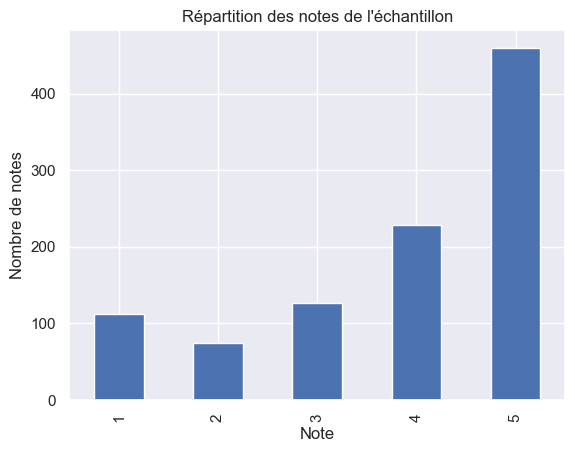

23% des reviews ont au maximum 2 étoiles


In [80]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar(xlabel="Note", ylabel="Nombre de notes", title="Répartition des notes de l'échantillon")
plt.show()

bad_stars = 2
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > bad_stars
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]
print(f'{sampling_coef_bad*100:.0f}% des reviews ont au maximum {bad_stars} étoiles')

In [81]:
printHtmlH("Apperçu des catégories", "4")
printHtmlList(list(preview_dfs['business']['categories'].unique()[0:20]) + ["etc..."], "ol")

In [82]:
printHtmlH("Apperçu de quelques reviews par note", "3")
review = preview_dfs['review']
for star in range(1,6):
    printHtmlH(f'Note = {star}', "4")
    display(HTML('<hr>'))
    for index in review[review['stars']==star].sample(2, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        quote = HTML(f'<div style="border-left: 4px solid yellow; padding-left:10px; margin-bottom:20px;">{text}</div>')
        display(quote)

## Extraction d'un échantillons de reviews

### Recensement des catégories de business

In [83]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

82695     [Furniture Stores, Shopping, Home & Garden, Ma...
148964                          [Restaurants, Asian Fusion]
12695                        [Food, Fast Food, Restaurants]
26570                     [Ice Cream & Frozen Yogurt, Food]
40670                        [Home Services, Home Cleaning]
Name: _cats, dtype: object

In [84]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [85]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Restaurants', 'Pop-Up Restaurants', 'Restaurant Supplies']

In [86]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Food Stands',
 'Food Trucks',
 'Specialty Food',
 'Seafood Markets',
 'Food Tours',
 'Food Court',
 'Ethnic Food',
 'Live/Raw Food',
 'Food Banks',
 'Comfort Food',
 'Seafood',
 'Food Delivery Services',
 'Fast Food',
 'Do-It-Yourself Food',
 'Imported Food',
 'Soul Food',
 'Food']

In [87]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')

52268 business sont des Restaurants


### Création des fichiers parquets

Caractéristique de l'extraction
- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation par note
- Ajout des infos business
- Limite en quantité: 1000 reviews par note
- Stockage dans des fichiers parquets

In [88]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_REVIEW_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_REVIEW_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_REVIEW_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2, stars = None):
    if stars:
        return pd.read_parquet(reviews_files[stars])
        
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

In [89]:
print(f'Exemple de dataFrame contenant les enregistrements qui ont au maximum {bad_stars} étoiles')
get_reviews(max_stars=bad_stars).sample(5)

Exemple de dataFrame contenant les enregistrements qui ont au maximum 2 étoiles


review_id                 user_id             business_id  \
index                                                                           
9463   kbFWqRvWRpgMn_CG0MyIOQ  QUPeCB9UKfGmrK31uDWleA  UmjITdXHhEF46ho6IhaGQg   
8700   aFSHsGHZJTz3wZ_BsFKyZA  9QquGkEEhr4WWFHqxT3Rbw  Q1HHAb4FzrzfnnrRyA8fgg   
11054  dixb4ba1DDMZNapHJrRpHw  NUtIAX-ygn474tDg5nmesg  -ATiAtTikuGuqvaW2O6tNA   
3225   ymbDu_j2XrNFcYItj4GWfw  noxaMHJFoBDFio1D3OF6Qg  ltBBYdNzkeKdCNPDAsxwAA   
6477   kkLwgG0IATXRuhmHlSG4Qg  FLgDQVXb4vWsKA2QXwA-tw  E-4t5Hoon6aVFTWDPz26fQ   

       stars  useful  funny  cool  \
index                               
9463       1       0      0     0   
8700       1       0      0     0   
11054      2       0      0     0   
3225       1       1      0     0   
6477       2       1      1     0   

                                                    text                date  \
index                                                                          
9463   horrible food! waited for my nachos that took ... 2017-10-11 01:17:10   
8700   A 12 dollar burger and fries that were not eve... 2015-02-02 22:51:05   
11054  Eh, disappointing food. I saw this place got b... 2015-02-16 05:53:31   
3225   I have never been so insulted and talked down ... 2017-06-17 21:02:18   
6477   Mediocre at best. Service was very slow. It to... 2013-06-24 18:03:50   

                           name  ...   latitude  longitude stars_business  \
index                            ...                                        
9463            Dave & Buster's  ...  29.950516 -90.076204            2.0   
8700   Cheeseburger in Paradise  ...  39.664583 -86.089236            3.0   
11054                  Marathon  ...  39.950483 -75.167331            3.5   
3225                     Tavern  ...  36.150900 -86.797012            4.0   
6477              Biscuits Cafe  ...  39.868795 -86.140713            4.0   

      review_count  is_open  \
index                         
9463           351        1   
8700           103        0   
11054          593        1   
3225          1222        1   
6477           308        1   

                                              attributes  \
index                                                      
9463   b'{"HappyHour":"True","GoodForKids":"True","Be...   
8700   b'{"Alcohol":"u\'full_bar\'","OutdoorSeating":...   
11054  b'{"RestaurantsAttire":"\'casual\'","Alcohol":...   
3225   b'{"BikeParking":"True","Alcohol":"u\'full_bar...   
6477   b'{"RestaurantsReservations":"False","HasTV":"...   

                                              categories  \
index                                                      
9463   Adult Entertainment, Sports Bars, Restaurants,...   
8700   Restaurants, Burgers, Bars, American (Traditio...   
11054  Sandwiches, American (New), Lounges, Nightlife...   
3225   Cocktail Bars, Nightlife, Gastropubs, Sports B...   
6477            Restaurants, Mexican, Breakfast & Brunch   

                                                   hours  \
index                                                      
9463   b'{"Monday":"0:0-0:0","Tuesday":"10:0-23:59","...   
8700   b'{"Monday":"11:0-0:0","Tuesday":"11:0-0:0","W...   
11054  b'{"Monday":"11:0-21:0","Tuesday":"11:0-21:0",...   
3225   b'{"Monday":"0:0-0:0","Wednesday":"10:0-22:0",...   
6477   b'{"Monday":"7:0-15:0","Tuesday":"7:0-15:0","W...   

                                                   _cats review_count_q  
index                                                                    
9463   b'["Adult Entertainment","Sports Bars","Restau...             c4  
8700   b'["Restaurants","Burgers","Bars","American (T...             c4  
11054  b'["Sandwiches","American (New)","Lounges","Ni...             c4  
3225   b'["Cocktail Bars","Nightlife","Gastropubs","S...             c4  
6477   b'["Restaurants","Mexican","Breakfast & Brunch"]'             c4  

[5 rows x 24 columns]

## Analyse des echantillons de reviews 

### Fonctions de traitement du text

In [90]:
def get_negative_sw():
    return [sw for sw in stopwords.words('english') if sw not in ['not', 'too', 'very', 'few',  "don't", "aren't", 'couldn',
                                                                  "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
                                                                  "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                                                                  "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                                                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
           ]

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

def extract_n_grams(token_list, n_list):
    import nltk
    n_grams = []
    for n in n_list:
        n_grams.append([' '.join(n_gram) for n_gram in nltk.ngrams(token_list,n)])

    new_token_list = []
    for n_gram in n_grams:
        new_token_list  = new_token_list + n_gram

    if 1 in n_list:
        new_token_list = token_list + new_token_list

    return new_token_list    
    
def display_word_cloud(reviews, no_below = 4, no_above = 0.1, max_words_in_cloud=50, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 0: display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)

    stop_words = get_negative_sw()
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()

    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    # View result sample
    if verbose > 0: 
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])

    # Calc and view text lengths
    if verbose > 0: 
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Text length
    total_text_len = reviews['text_len'].sum()
    if verbose > 0: 
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
        print('')

    # Visualisation Word clound on sample
    # Sampling for word cloud
    cloud_sample_size = min(reviews.shape[0], 1000)
    sample = reviews.sample(cloud_sample_size, random_state=0)['tokens']

    # Filter extremes filter
    dictionary = corpora.Dictionary(list(sample))
    dictionary.filter_extremes(no_below=2, no_above=0.1)
    sample.parallel_apply(lambda tokens: [token for token in tokens if token in list(dictionary.values())])
    
    if verbose > 0: print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')

    # Join text and display wordcloud
    sample_text = ' '.join(sample.str.join(' ').values)
    wordcloud = WordCloud(background_color = 'white', max_words = max_words_in_cloud).generate(sample_text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();
    print('')

### Nuages de mots par note

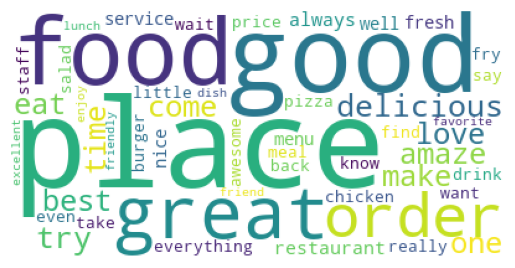

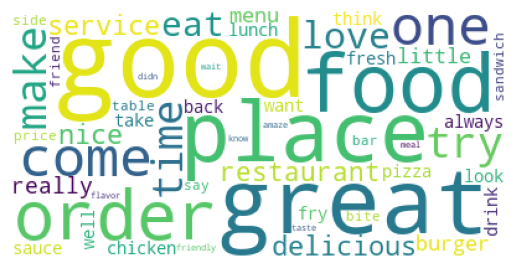

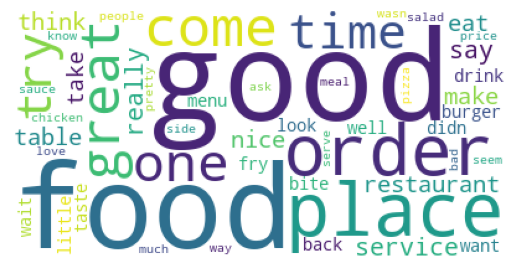

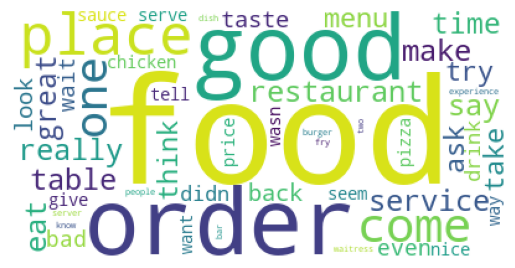

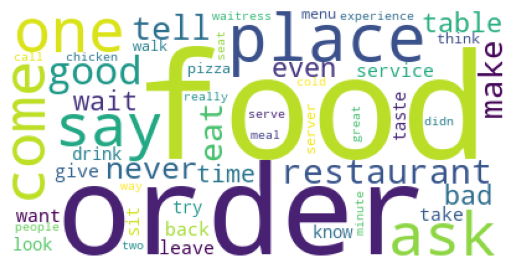

In [91]:
for stars in range(5,0,-1):
    printHtmlH(f'Note = {stars}', "4")
    display_word_cloud(reviews=get_reviews(stars=stars),
                       no_below=2,
                       no_above= 0.1, 
                       max_words_in_cloud=50)

## Recherche des sujets d'insatisfactions

### Sac de mots (TF-IDF)

In [92]:
def tf_idf(reviews, min_df = 4, max_df = 100, ngram_range=(1,2), verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words=get_negative_sw(), sublinear_tf=True,ngram_range=ngram_range)
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        reviews.reset_index(inplace=True)
        for index in reviews[reviews['text'].str.len() < 500].sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[100, None]))

    return values, vectorizer.get_feature_names_out()

In [93]:
print(f'Vectorisation pour les reviews comportant maximum {bad_stars} étoiles')
reviews = get_reviews(max_stars=bad_stars)
values, features_names = tf_idf(reviews=reviews,
                                min_df=10,
                                max_df=0.1,
                                ngram_range=(1,2),
                                verbose=1)

Vectorisation pour les reviews comportant maximum 2 étoiles
Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements

Vecteurs TF-IDF des reviews:


100  1st  2nd  able  absolute  absolutely  accept  accommodate  \
0  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
1  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
2  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
3  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
4  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   

   acknowledge  across  ...  yelp       yes  yesterday  yet  york  young  \
0          0.0     0.0  ...   0.0  0.231769        0.0  0.0   0.0    0.0   
1          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
2          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
3          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
4          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   

   yuck  yummy      zero  zero star  
0   0.0    0.0  0.000000        0.0  
1   0.0    0.0  0.000000        0.0  
2   0.0    0.0  0.176228        0.0  
3   0.0    0.0  0.000000        0.0  
4   0.0    0.0  0.000000        0.0  

[5 rows x 1901 columns]

+------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                          | vecteur tf-idf           |
+======================================================================================================+==========================+
| You don't accept cash?  I don't think you grasp the ramifications of such a corpo-fascist economic   | accept: 0.2965           |
| principle.  No room for arrogant commies in my diet thank you so very very little.  Can't wait to    | anyone: 0.2395           |
| see this place nosedive  For anyone in the dark about this policy,  watch Mike Judge's film,         | attention: 0.2499        |
| Idiocracy. Pay close attention throughout the hospital scene.   "Unscannable!!!"                     | cash: 0.2758             |
|                                                                           

### LDA (Librairie Sklearn)

In [94]:
def get_topics(reviews: pd.DataFrame, min_df = 4, max_df = 10, n_topics = 10, alpha = 10, n_top_words = 10, ngram_range=(1,1), verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)
    
    if verbose > 1: print('  - Vectorisation (tf-idf)')
    values, features_names = tf_idf(reviews=reviews, min_df=min_df, max_df=max_df, ngram_range=ngram_range, verbose = 0)

    # Topics from LDA or MDF
    if verbose > 1: print('  - Modélisation LDA')
    model = LatentDirichletAllocation(n_components=n_topics,
                                      max_iter=10,
                                      doc_topic_prior=alpha,
                                      learning_method='online', 
                                      learning_offset=10,
                                      random_state=0,
                                      n_jobs=-1)
    
    model.fit(values)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        features = [features_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)

    return topics

In [95]:
params = {
    'max_stars': bad_stars,
    'min_df': 2,
    'max_df': 0.1,
    'n_topics': 3,
    'alpha': 0.5,
    'n_top_words': 5,
    'ngram_range': (1,1)
}

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.1
n_topics     3
alpha        0.5
n_top_words  5
ngram_range  (1, 1)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  ---------------------------------------
         0  pizza, waitress, burger, sauce, bar
         1  mahi, vista, isla, cashew, angelo
         2  donut, fancy, environment, refer, bueno


In [96]:
params['alpha'] = 0.8
params['max_df'] = 0.2
params['ngram_range'] = (3,3)

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.2
n_topics     3
alpha        0.8
n_top_words  5
ngram_range  (3, 3)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  ----------------------------------------------------------------------------------------------
         0  would not recommend, waste time money, wait another minute, not recommend place, give one star
         1  not very good, want like place, food good service, nothing write home, give two star
         2  take minute get, not worth wait, service very slow, food nothing special, not worth price


### LDA (Librairie Gensim)

In [97]:
def prepare_data(max_stars=2, n_grams=[1,2], no_below=2, no_above=0.1):
    print('  - Préparation des data (preprocess tokenisation...)')

    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=False, verbose=False)
    
    # Preprocess, tokenize and drop stop words
    reviews = get_reviews(max_stars=max_stars)
    texts = reviews['text'].parallel_apply(preprocess_text)
    texts = texts.parallel_apply(tokenize)
    stop_words = get_negative_sw()
    texts = texts.parallel_apply(drop_words, args=(stop_words,))
    
    # Managing n_grams
    texts = texts.parallel_apply(extract_n_grams, args=(n_grams,))

    # list texts
    texts = list(texts)
    
    # create document terms matrix
    dictionary = corpora.Dictionary(texts)
    
    #filter extremes
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    corpus = [dictionary.doc2bow(text) for text in texts]

    return texts, dictionary, corpus

def modelize(dictionary, corpus, alpha = 10, num_topics = 10):
    print(f'  - LDA pour {num_topics} topics')
    LDA = gensim.models.ldamodel.LdaModel
    model = LDA(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, random_state=0, chunksize=1000, passes=50,iterations=100)
    return model

def visualize_model(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis

def print_topics(model):
    topics = []
    for topic in model.show_topics():
        index = topic[0] + 1
        terms = '\n'.join(topic[1].split(' + '))
        topics.append([index, terms])
    
    print(tabulate(topics, headers=['Topic n°', 'mots clés'], tablefmt="grid"))

In [98]:
texts, dictionary, corpus = prepare_data(max_stars=2, n_grams=[2,3], no_below=2, no_above=0.2)
model = modelize(dictionary=dictionary, corpus=corpus, num_topics=3)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 3 topics
+------------+--------------------------+
|   Topic n° | mots clés                |
+============+==========================+
|          1 | 0.004*"taste like"       |
|            | 0.004*"come back"        |
|            | 0.003*"win back"         |
|            | 0.003*"food not"         |
|            | 0.002*"not good"         |
|            | 0.002*"mac cheese"       |
|            | 0.002*"wait staff"       |
|            | 0.001*"felt like"        |
|            | 0.001*"very good"        |
|            | 0.001*"place not"        |
+------------+--------------------------+
|          2 | 0.002*"not worth"        |
|            | 0.002*"look like"        |
|            | 0.002*"next time"        |
|            | 0.002*"much good"        |
|            | 0.002*"very disappoint"  |
|            | 0.002*"not sure"         |
|            | 0.002*"first time"       |
|            | 0.002*"come back"        |


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.159450 -0.011734       1        1  33.735093
0      0.090075 -0.129716       2        1  33.383980
1      0.069375  0.141450       3        1  32.880927, topic_info=             Term       Freq       Total Category  logprob  loglift
97     taste like  96.000000   96.000000  Default  30.0000  30.0000
71       get food  61.000000   61.000000  Default  29.0000  29.0000
2046   last night  35.000000   35.000000  Default  28.0000  28.0000
975   wait minute  49.000000   49.000000  Default  27.0000  27.0000
169      food not  52.000000   52.000000  Default  26.0000  26.0000
...           ...        ...         ...      ...      ...      ...
63      come back  28.714865  121.531101   Topic3  -6.4109  -0.3305
2184     one star  18.620230   30.926835   Topic3  -6.8441   0.6049
2826  even though  19.725269   47.432808   Topic3  -6.7864   0.2349
1285    food come  18.671544   36.723787   Topic3  -6.8413   0.4359
112     didn even  18.811760   43.610442   Topic3  -6.8339   0.2715

[219 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
2886      3  0.948824        across street
1546      1  0.916757        almost minute
2201      1  0.958333             ask move
1039      2  0.917524         average food
1284      1  0.866426       bad experience
...     ...       ...                  ...
1037      2  0.118084            would not
1037      3  0.059042            would not
2868      1  0.899299  would not recommend
2868      2  0.074942  would not recommend
2125      1  0.971013            zero star

[337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [99]:
texts, dictionary, corpus = prepare_data(max_stars=1, n_grams=[3], no_below=2, no_above=0.1)
model = modelize(dictionary=dictionary, corpus=corpus, alpha=20, num_topics=3)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 3 topics
+------------+-----------------------------+
|   Topic n° | mots clés                   |
+============+=============================+
|          1 | 0.009*"never come back"     |
|            | 0.008*"waste time money"    |
|            | 0.005*"could give zero"     |
|            | 0.004*"would not recommend" |
|            | 0.004*"get money back"      |
|            | 0.004*"take drink order"    |
|            | 0.004*"buy one get"         |
|            | 0.004*"not come back"       |
|            | 0.003*"take minute get"     |
|            | 0.003*"get order right"     |
+------------+-----------------------------+
|          2 | 0.005*"want like place"     |
|            | 0.005*"take minute get"     |
|            | 0.004*"speak manager tell"  |
|            | 0.004*"say didn know"       |
|            | 0.004*"never come back"     |
|            | 0.004*"make eye contact"    |
|            | 0.004*"wo

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.004563 -0.019382       1        1  33.371427
1     -0.021508  0.006242       2        1  33.331019
2      0.016946  0.013141       3        1  33.297554, topic_info=                      Term      Freq     Total Category  logprob  loglift
192     speak manager tell  4.000000  4.000000  Default  30.0000  30.0000
129        come take order  6.000000  6.000000  Default  29.0000  29.0000
69        waste time money  9.000000  9.000000  Default  28.0000  28.0000
150         last time come  2.000000  2.000000  Default  27.0000  27.0000
154  lack customer service  2.000000  2.000000  Default  26.0000  26.0000
..                     ...       ...       ...      ...      ...      ...
67     wait another minute  1.846004  5.672608   Topic3  -5.8937  -0.0229
69        waste time money  2.124766  9.931349   Topic3  -5.7530  -0.4423
214          give one star  1.762124  4.963941   Topic3  -5.9402   0.0640
330        take minute get  1.832554  7.091232   Topic3  -5.9010  -0.2535
236    would not recommend  1.786240  7.092200   Topic3  -5.9266  -0.2792

[199 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
371       2  0.470191  another minute drink
739       1  0.469911    another minute get
182       1  0.176287     ask speak manager
182       2  0.352573     ask speak manager
182       3  0.352573     ask speak manager
...     ...       ...                   ...
236       3  0.282000   would not recommend
539       2  0.470171      would waste time
195       1  0.402883       zero star would
195       2  0.402883       zero star would
195       3  0.201442       zero star would

[315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

# Classifications des images

## Prévisualisation du dataset

In [100]:
df_photos = pd.read_json('data/original/yelp_photos/photos.json', lines=True)
df_photos.sample(5)

photo_id             business_id  \
194930  tZbRbPvEl-JbyLJs2o8hPA  winkCYdiTroKdbPbV0DfRA   
108928  7NJR2R67yWRN42NGJB_XwA  _OMGZ3TXOfN2By7skat_bw   
96861   p1DZ4TCwTePXbogCscsS0w  HJ_rOClY2RPrdervYopKmQ   
158324  8mGZXmWyxdjHHjnat-6raw  u5_y_iOUMjbvqSwWXIx-5A   
163617  VpTbBJ2f3CejijtVNgFO9Q  dGaZVxymBQVmYxl70Q9ZzA   

                                 caption   label  
194930  Beautiful decked out restaurant.  inside  
108928                                      food  
96861                                     inside  
158324                                    inside  
163617                                      food

In [101]:
df_photos.shape

(200100, 4)

In [102]:
df_photos.label.value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

## Creation dataset echantillons

L'échantillon contient 500 images


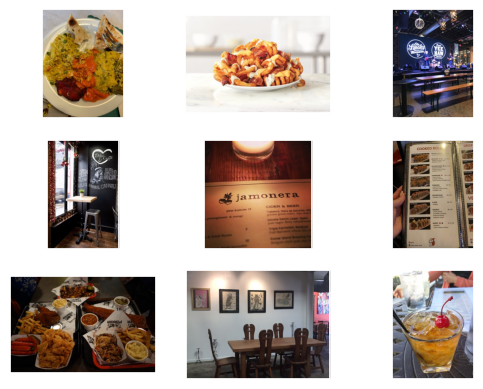

In [103]:
def get_original_photo_path(photo_id):
    return ORIGINAL_PHOTOS_DIR + 'photos/' + photo_id + '.jpg'
    
photo_ids = {}
df_photos_sampling = pd.DataFrame()
for label in df_photos.label.unique():
    photo_ids = list(df_photos[df_photos.label == label].sample(SAMPLING_PHOTOS_SIZE, random_state=0)['photo_id'])
    df_label = pd.DataFrame({
        'photo_id': photo_ids,
        'label': np.full(len(photo_ids), label),
        'width': np.zeros(len(photo_ids)), 
        'height': np.zeros(len(photo_ids)), 
        'mode': np.full(len(photo_ids), '')
    })
    df_photos_sampling = pd.concat([df_photos_sampling, df_label], ignore_index=True)

label_encoder = LabelEncoder()
df_photos_sampling['label_num'] = label_encoder.fit_transform(df_photos_sampling['label'])

print(f'L\'échantillon contient {df_photos_sampling.shape[0]} images')

sample_ids = list(df_photos_sampling.sample(9, random_state=1)['photo_id'])
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = matplotlib.image.imread(get_original_photo_path(sample_ids[i]))
    plt.imshow(image)
    plt.grid(linewidth=0)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.show()

In [104]:
def fill_infos(df):
    for index in df.index:
        print(f'Lecture infos image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        img = Image.open(get_original_photo_path(photo_id))
        
        w, h = img.size
        df.loc[df['photo_id']==photo_id, 'height'] = h   
        df.loc[df['photo_id']==photo_id, 'width'] = w
        df.loc[df['photo_id']==photo_id, 'mode'] = img.mode

fill_infos(df_photos_sampling)
df_photos_sampling.sample(5)

photo_id    label  width  height mode  label_num
240  WWKvN7U_er2nrM3o6GUrMA    drink  455.0   400.0  RGB          0
321  kiIpYRFbv6meUfj31B2Rng     food  400.0   400.0  RGB          1
174  KdU3pcSv61Ri-i5R27yTsg  outside  600.0   399.0  RGB          4
410  7SVXdIwGh1ePmnlkw2dspA     menu  533.0   400.0  RGB          3
188  NSNssQH5t6UNbcSvbrSGvg  outside  533.0   400.0  RGB          4

In [105]:
df_photos_sampling.describe()

width      height  label_num
count  500.000000  500.000000  500.00000
mean   438.882000  389.688000    2.00000
std    131.985303   32.814085    1.41563
min    131.000000   69.000000    0.00000
25%    300.000000  400.000000    1.00000
50%    408.000000  400.000000    2.00000
75%    543.750000  400.000000    3.00000
max    600.000000  400.000000    4.00000

In [106]:
df_photos_sampling['mode'].value_counts()

mode
RGB    500
Name: count, dtype: int64

## Clustering par descripteurs SIFT

In [107]:
df_sift = df_photos_sampling.copy()

### Pretraitement des images

In [108]:
def preprocess_images_sift(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image_sift(photo_id)

def preprocess_image_sift(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        printHtmlH('Image et son histogramme avant traitement', '4')
        img = display_img(original_path)
        img = histo_rgb(img)
    else:
        img = Image.open(original_path)
    
    img = treat_histogram(img)
    img = filter_img(img)
    new_path = save_img(current_path=original_path, img=img, work_part='sift')

    if display_evo:
        printHtmlH('Image et son histogramme après traitement', '4')
        img = display_img(new_path)
        img = histo_rgb(img)
    
    return new_path
    
def display_img(path):
    img = Image.open(path)
    display(img)
    return img

def histo_rgb(img):
    r, g, b = img.split()
    fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True)
    chans = {'rouge': r, 'vert': g, 'bleu':b}
    for index, name in enumerate(chans):
        chan_flat = np.array(chans[name]).flatten()
        ax = sns.histplot(chan_flat, bins=range(256), ax=axs[index])
        ax.set(ylabel=None,
               title=f'Channel: {name}')
    fig.supxlabel('Intensité')
    fig.supylabel('Nombre de pixels')
    plt.show()

    return img

def treat_histogram(img):
    # Equalize and autocontrast
    img = ImageOps.equalize(img)
    img = ImageOps.autocontrast(img)
    return img
    

def filter_img(img):
    # Apply gaussian blur
    img = img.filter(ImageFilter.MedianFilter(size=3))
    return img

def save_img(current_path, img, work_part):
    filename = os.path.basename(current_path)
    new_path = WORK_PHOTOS_DIR + work_part + '/' + filename
    img.save(new_path)

    return new_path

#### Exemple de pre-traitement

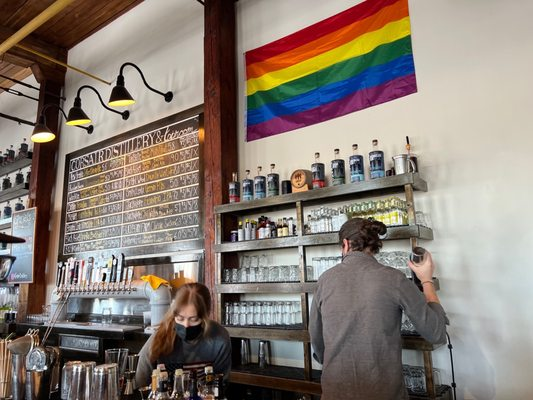

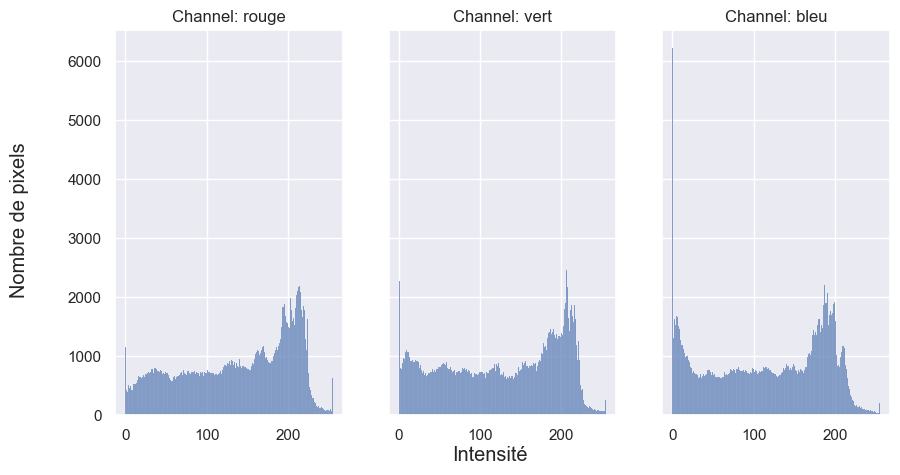

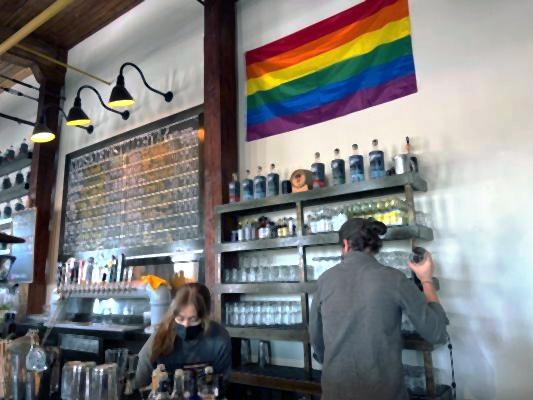

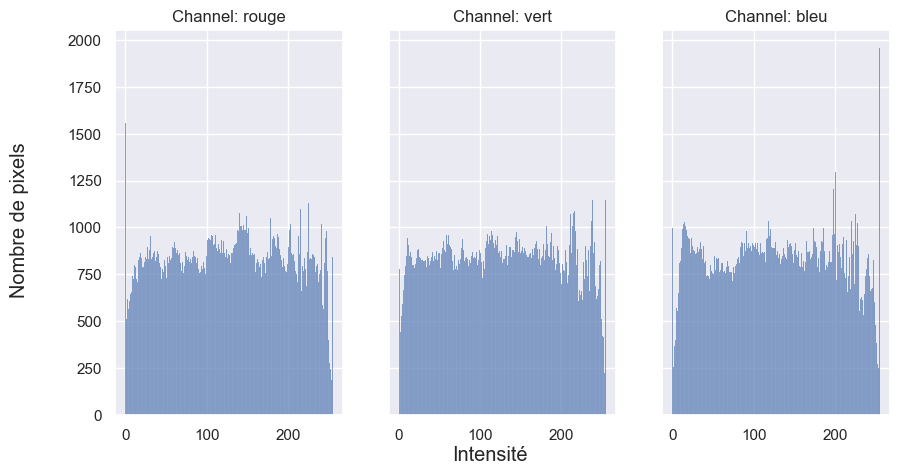

In [109]:
photo_id_sample = df_sift.sample(1, random_state=0)['photo_id'].iloc[0]
file = preprocess_image_sift(photo_id_sample,display_evo=True)

#### Pretaitement de l'ensemble de l'échantillon

In [110]:
if PREPROCESS_IMAGES:
    preprocess_images_sift(df=df_sift)

### Creation des descripteurs

In [111]:
def get_descripteurs(photo_id, max_desc=500, work_dir = WORK_PHOTOS_DIR, plot = False, print_desc = False):
    import cv2
    sift = cv2.xfeatures2d.SIFT_create(max_desc)
    image = cv2.imread(work_dir + 'sift/' + photo_id + '.jpg')
    kp, desc = sift.detectAndCompute(image, None)

    if plot:
        img=cv2.drawKeypoints(image,kp,image)
        plt.imshow(img)
        plt.grid(linewidth=0)
        plt.show()

    if print_desc:
        print("Descripteurs : ", desc.shape)
        print()
        print(desc)
    
    return desc    

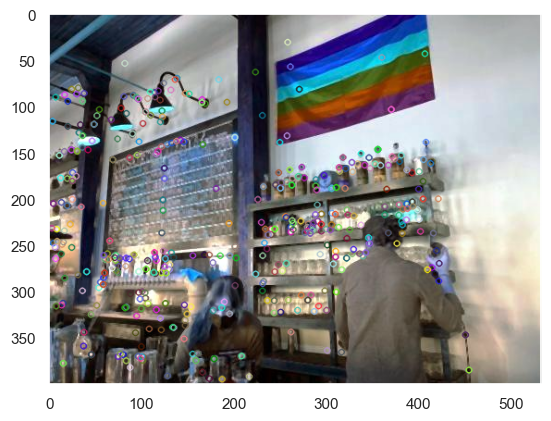

Descripteurs :  (501, 128)

[[ 0.  0.  0. ...  1. 18. 18.]
 [13. 14.  8. ... 24.  0.  1.]
 [24.  0.  0. ...  2.  5. 25.]
 ...
 [ 0.  0.  0. ...  0.  2.  8.]
 [ 0.  0.  0. ...  0.  2. 13.]
 [ 0.  0. 10. ...  0.  0. 12.]]


In [112]:
printHtmlH('Exemple de descripteur', '4')
desc = get_descripteurs(photo_id=photo_id_sample, plot=True, print_desc=True)

In [113]:
pandarallel.initialize(progress_bar=True, verbose=False)
descripteurs = df_sift['photo_id'].parallel_apply(get_descripteurs, args=(500,))
df_sift['desc'] = descripteurs
display(df_sift.sample(3))
num_img_desc = df_sift['desc'][0].shape[0]

photo_id    label  width  height mode  label_num  \
33   7d3F_rofryuhXqnCqvXf6A   inside  400.0   400.0  RGB          2   
166  lhAjL7H5xuynga18TcPReA  outside  300.0   400.0  RGB          4   
336  XYl8T4g60GxHCcZzS0NKrw     food  400.0   400.0  RGB          1   

                                                  desc  
33   [[23.0, 96.0, 81.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1...  
166  [[26.0, 3.0, 0.0, 1.0, 70.0, 13.0, 0.0, 0.0, 1...  
336  [[25.0, 1.0, 0.0, 2.0, 114.0, 23.0, 0.0, 0.0, ...

### Clustering des descripteurs

Principe:
- Il s'agit de regrouper tous les descripteurs en clusters
- Les clusters serviront ensuite à classifier les images par degré d'appartenance à chaque cluster

In [114]:
all_descripteurs = np.concatenate(df_sift['desc'].values, axis=0)
n_clusters = math.floor(math.sqrt(len(all_descripteurs)))
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=512, random_state=0, n_init="auto").fit(all_descripteurs)
print(f'Il y a {n_clusters} clusteurs pour un total de {len(all_descripteurs)} descripteurs')

Il y a 494 clusteurs pour un total de 244742 descripteurs


### Creations des features des images

Principes:

- On attribut chacun des descripeurs de l'image à un des clusters de descripteur
- Pour chacun des clusteurs on compte combien l'image contient de descripteur de ce clusteur
- On peut le visualiser en forme d'histogramme et utiliser celui comme features de l'image

In [115]:
def features_sift(descripteurs, kmeans: MiniBatchKMeans):
    import numpy as np
    desc_clusters = kmeans.predict(descripteurs)
    return np.histogram(desc_clusters, bins=kmeans.n_clusters, range=(0, kmeans.n_clusters))[0]

features = df_sift['desc'].parallel_apply(features_sift, args=(kmeans,))
df_sift['features'] = features
df_sift.sample(3)

photo_id    label  width  height mode  label_num  \
141  HIDivevBlu2KTM2Cz4Rw7g  outside  600.0   400.0  RGB          4   
42   buJb1BNmRA_ewTA2k1GTxg   inside  600.0   337.0  RGB          2   
23   nBV7vIJvFw5vhf8iUYjEbA   inside  600.0   399.0  RGB          2   

                                                  desc  \
141  [[29.0, 12.0, 8.0, 10.0, 1.0, 0.0, 3.0, 5.0, 1...   
42   [[43.0, 8.0, 0.0, 0.0, 4.0, 10.0, 7.0, 10.0, 1...   
23   [[122.0, 4.0, 3.0, 5.0, 0.0, 0.0, 0.0, 122.0, ...   

                                              features  
141  [2, 1, 1, 0, 1, 1, 0, 0, 0, 2, 1, 3, 5, 3, 2, ...  
42   [2, 0, 2, 0, 0, 0, 1, 1, 1, 4, 0, 0, 2, 0, 0, ...  
23   [0, 2, 1, 3, 1, 1, 3, 0, 0, 1, 3, 0, 0, 1, 1, ...

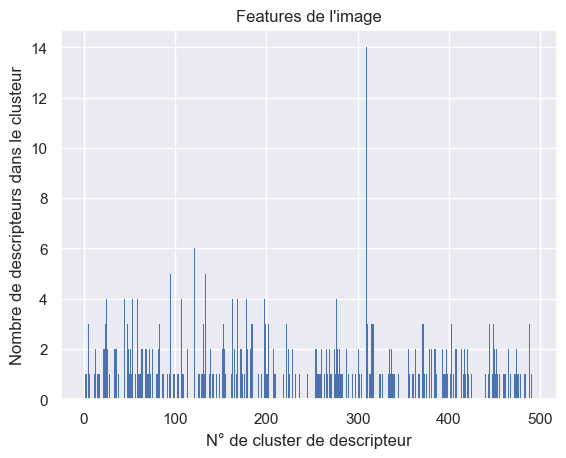

In [116]:
features_sample = df_sift['features'][0]
plt.bar(range(len(features_sample)), features_sample, linewidth=0)
plt.xlabel('N° de cluster de descripteur')
plt.ylabel('Nombre de descripteurs dans le clusteur')
plt.title('Features de l\'image')
plt.show()

### Reduction de dimension puis clustering

In [117]:
def acp(X, keep_variance = 0.99):
    print('Reduction PCA')
    pca = PCA(n_components=keep_variance, svd_solver='full')
    features_pca = pca.fit_transform(X)
    old_shape = np.array(X)[0].shape[0]
    new_shape = features_pca.shape[1]
    print(f'En concervant {keep_variance*100}% de la variance, la PCA réduit les features de {old_shape} composantes à {new_shape} composantes') 

    return features_pca

def tsne_df(df, label, features, x_tsne, y_tsne):
    print('Reduction TSNE en 2 dimensions')
    tsne = TSNE(n_components=2, perplexity=20, n_iter=15000, init='random', random_state=0)
    X_tsne = tsne.fit_transform(features)
    
    df[x_tsne] = X_tsne[:,0:1]
    df[y_tsne] = X_tsne[:,1:2]
    
    sns.scatterplot(df, x=x_tsne, y=y_tsne, hue=label)
    plt.xlabel('DIM 1')
    plt.ylabel('DIM 2')
    plt.title('Dataset réduit en 2 dimensions')
    plt.show()

def clustering(df, X, label, predict):
    print('Clustering')
    n_clusters = df[label].nunique()
    kmean_final = MiniBatchKMeans(n_clusters=5, batch_size=512, random_state=0, n_init="auto").fit(X)
    df[predict] = kmean_final.predict(X)

def graph_predict(df, x, y, label, predict, label_classes):
    print('Affichage des clusters')
    sns.scatterplot(df, x=x, y=y, hue=predict)
    plt.xlabel('DIM 1')
    plt.ylabel('DIM 2')
    plt.title('Prédiction')
    plt.show()

    labels_true = list(df[label])
    labels_pred = list(df[predict])
    
    conf_mat = confusion_matrix(labels_true, labels_pred)
    plt.figure(figsize = (6,4))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", yticklabels=label_classes)
    plt.title('Correlation des labels réels et des prédictions')
    plt.show()

    ars = adjusted_rand_score(labels_pred=labels_pred, labels_true=labels_true)
    printHtmlH(f'Adjusted rand score = {ars:.3f}', '3')

def pca_tsne_clustering(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)

    # Step 2 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 3: Clustering
    X_clustering = np.array([df[x_tsne], df[y_tsne]]).T
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

def clustering_pca_tsne(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: Clustering
    X_clustering = list(df['features'])
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 2: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)

    # Step 3 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

def pca_clustering_tsne(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)
    
    # Step 2: Clustering
    X_clustering = features_pca
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 3 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 494 composantes à 338 composantes
Reduction TSNE en 2 dimensions


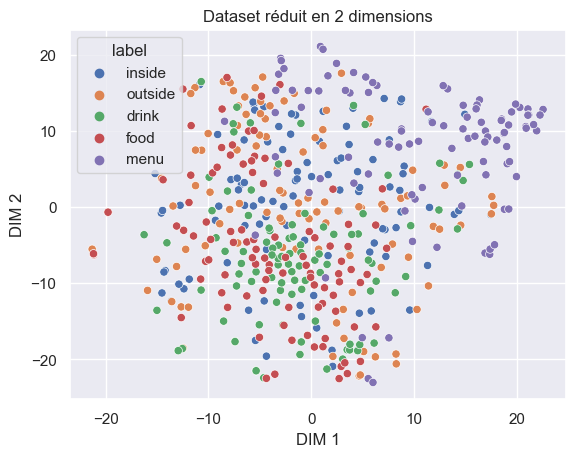

Clustering
Affichage des clusters


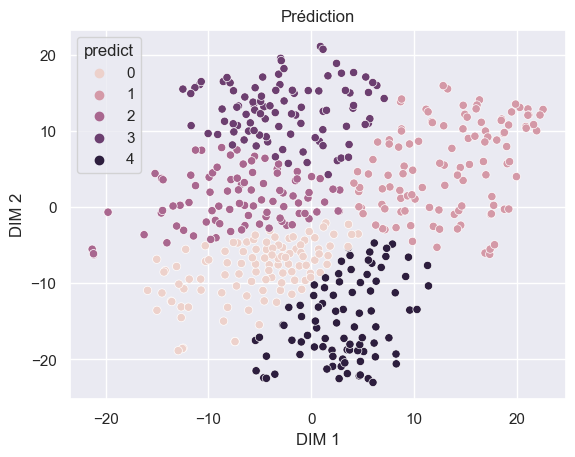

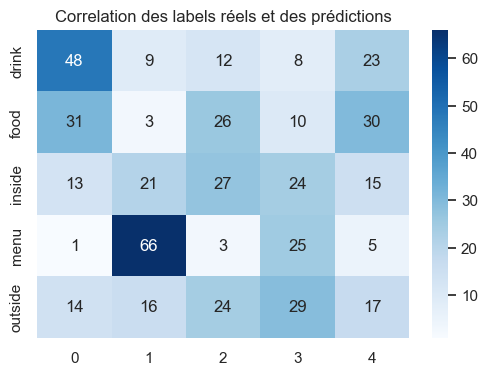

In [118]:
pca_tsne_clustering(df=df_sift, x_tsne='x_tsne', y_tsne='y_tsne', predict = 'predict')

## Clustering par CNN

In [119]:
df_cnn = df_photos_sampling.copy()

### Pretraitement des images

In [120]:
(width_max, height_max) = (int(df_cnn['width'].max()), int(df_cnn['height'].max()))

In [121]:
from PIL import Image, ImageOps

def preprocess_images_cnn(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image_cnn(photo_id)

def preprocess_image_cnn(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        printHtmlH('Image avant traitement', '4')
        img = display_img(original_path)
        print(f'Taille originale => Hauteur: {img.height}, Largeur: {img.width}')
    else:
        img = Image.open(original_path)

    border_width_1 = (width_max - img.width) // 2
    border_width_2 = width_max - img.width - border_width_1
    
    border_height_1 = (height_max - img.height) // 2
    border_height_2 = height_max - img.height - border_height_1
    
    img = ImageOps.expand(img,border=(border_width_1, border_height_1, border_width_2, border_height_2),fill='black')
    
    new_path = save_img(current_path=original_path, img=img, work_part='cnn')

    if display_evo:
        printHtmlH('Image après traitement', '4')
        img = display_img(new_path)
        print(f'Taille ajustée => Hauteur: {img.height}, Largeur: {img.width}')
    
    return new_path

### Exemple de pré-traitement

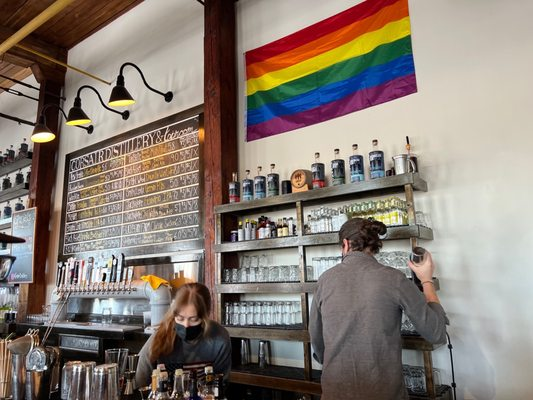

Taille originale => Hauteur: 400, Largeur: 533


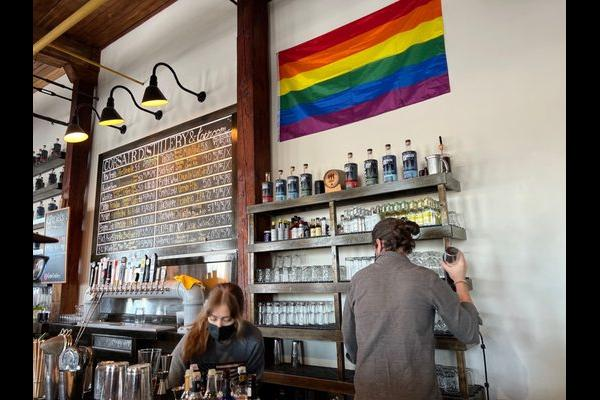

Taille ajustée => Hauteur: 400, Largeur: 600


In [122]:
file = preprocess_image_cnn(photo_id=photo_id_sample, display_evo=True)

### Pré-traitement de l'ensemble de l'échantillon

In [123]:
if PREPROCESS_IMAGES:
    preprocess_images_cnn(df=df_cnn)

### Creation des features depuis cnn VGG16

Principe:

- On utilise VGG16 sans la partie top (sans le reseau dense)
- On extrait un vecteur 1*512 du reseau CNN pour chaque image par prédiction
- Ce vecteur représente les features de l'image: comme pour sift on réduit en 2 dimensions puis on crée des clusters des images

In [124]:
from keras.applications.vgg16 import VGG16
from keras import Input
input = Input(shape=(height_max, width_max, 3))
model = VGG16(include_top=False,input_tensor=input, weights='imagenet', pooling='max')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 600, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 600, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 600, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 300, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 300, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 300, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 150, 128)     0     

In [125]:
import keras
def features_cnn(photo_id, model, work_dir = WORK_PHOTOS_DIR):
    img_path = work_dir + 'cnn/' + photo_id + '.jpg'
    img = keras.utils.load_img(img_path)
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.vgg16.preprocess_input(x)
    features = model.predict(x)
    
    return features[0, :]

In [126]:
df_cnn_parquet = WORK_PHOTOS_DIR + 'df_cnn.parquet'
if EXTRACT_CNN_FEATURES:
    features = df_cnn['photo_id'].apply(features_cnn, args=(model,))
    df_cnn['features'] = features
    df_cnn.to_parquet(df_cnn_parquet)
    df_cnn.sample(3)
else:
    df_cnn = pd.read_parquet(df_cnn_parquet)

In [127]:
df_cnn.sample(5)

photo_id    label  width  height mode  label_num  \
123  agDhgOFpoa460F5OXT8LTg  outside  300.0   400.0  RGB          4   
103  e9dWC-BEkpNVKyQMtqQUIg  outside  300.0   400.0  RGB          4   
347  cCzpY24isZOoDz3w_jU-8w     food  600.0   337.0  RGB          1   
382  xWdAaEFcAqgv7JzzGJZPSg     food  300.0   400.0  RGB          1   
127  YV6S7khxVDUiXd9Kp_HRTQ  outside  533.0   400.0  RGB          4   

                                              features  
123  [0.0, 19.520771, 9.291149, 8.395363, 30.872818...  
103  [0.0, 0.0, 0.0, 0.0, 23.90583, 0.0, 36.29199, ...  
347  [38.306427, 25.20011, 42.20351, 49.505047, 32....  
382  [59.417545, 25.74583, 65.44023, 85.79664, 49.2...  
127  [0.0, 12.044657, 1.1186492, 35.054287, 41.0022...

### Test 1: PCA -> TSNE -> KMEAN

Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 512 composantes à 339 composantes
Reduction TSNE en 2 dimensions


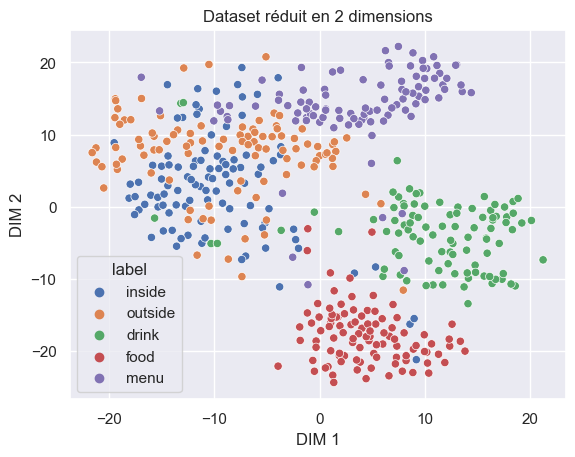

Clustering
Affichage des clusters


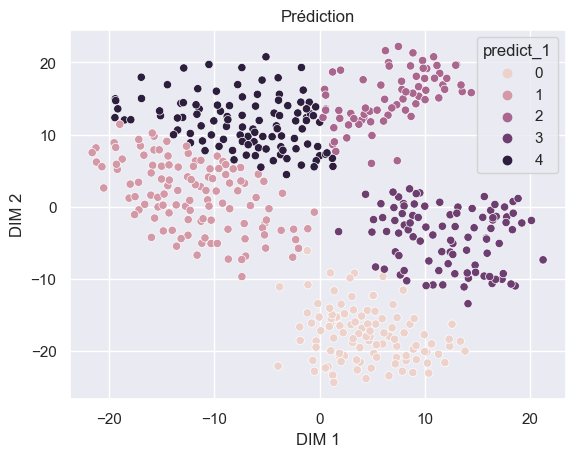

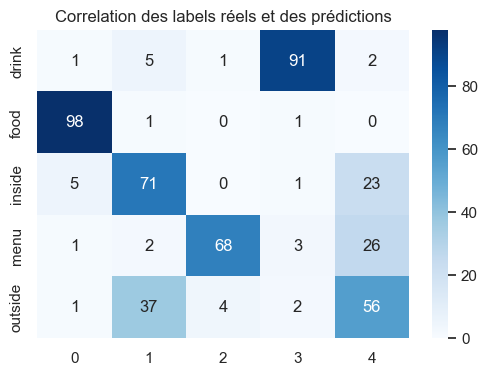

In [128]:
pca_tsne_clustering(df=df_cnn, x_tsne='x_tsne_1', y_tsne='y_tsne_1', predict='predict_1')

### Test 2: KMEAN -> PCA -> TSNE

In [ ]:
clustering_pca_tsne(df=df_cnn, x_tsne='x_tsne_2', y_tsne='y_tsne_2', predict='predict_2')

Clustering
Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 512 composantes à 339 composantes
Reduction TSNE en 2 dimensions


### Test 3: PCA (50% variance) -> KMEAN -> TSNE

In [ ]:
pca_clustering_tsne(df=df_cnn, x_tsne='x_tsne_3', y_tsne='y_tsne_3', predict='predict_3', pca_keep_variance=0.5)

# Récupération des données depuis l'API YELP

Principes:
- Faire une 1ere requete sur le point de terminaison "search" pour extraire 200 id de restaurant (une boucle avec offset sera néésssaire car le max par requete est 50)
- Faire une seconde requete en boucle sur les id des restaurants sur le point de terminaison "reviews" (3 reviews max en version gratuite sont données)
- Mettre les data dans des DataFrames puis sauver ces DataFrames en fichier parquet

In [ ]:
def request_yelp(ville: str, nombre_restau: int):
    file_reviews = WORK_DATASET_DIR + 'reviews_request.parquet'
    
    if not REQUEST_YELP:
        print('Read from previous requested (because of daily rate API limits)')
        return pd.read_parquet(file_reviews)

    try:
        authorization = f'Bearer {YELP_API_KEY}'
        headers = {
            'Authorization': authorization,
            'accept': 'application/json'
        }
        
        # GET Business Ids
        print('search request yelp in progress')
        nombre_restau = min(nombre_restau, 200)
        limit = min(nombre_restau, 50)
        df_businesses = pd.DataFrame()
        url = 'https://api.yelp.com/v3/businesses/search'
        params={
            'location': ville,
            'categories': 'Restaurant',
            'sort_by': 'best_match',
            'limit': str(limit),
            'offset': '0'
        }
        for offset in range(0, nombre_restau, limit):
            params['offset'] = str(offset)
            response_businesses = requests.get(url=url, params=params, headers=headers)
            new_records = pd.DataFrame.from_records(response_businesses.json()['businesses'])
            df_businesses = pd.concat([df_businesses, new_records], ignore_index=True)
        
        # Get Reviews
        businesses_id = list(df_businesses['id'])
        params={
            'limit': '50', # Free account limit to 3 reviews per id...
            'offset': '0'
        }
        df_reviews = pd.DataFrame()
        for id in businesses_id:
            url = f'https://api.yelp.com/v3/businesses/{id}/reviews'
            response_reviews = requests.get(url=url, params=params, headers=headers)
            new_records = pd.DataFrame.from_records(response_reviews.json()['reviews'])
            df_reviews = pd.concat([df_reviews, new_records], ignore_index=True) 

        
        df_reviews = df_reviews.loc[:, ['text', 'rating']]
        df_reviews.to_parquet(file_reviews, engine='fastparquet')
        
        print('Succès!')
        return df_reviews
        
    except Exception as err:
        print(f'Une erreur est renvoyée: {err}')  

In [ ]:
# REQUEST YELP HERE
ville = 'Paris'
nb_restau = 200
df_reviews_request = request_yelp(ville=ville, nombre_restau=nb_restau)

In [ ]:
print('Extrait des reviews provenant de l\'API YELP')
display(df_reviews_request.sample(5))
print(f'Il y a {df_reviews_request.shape[0]} enregistrements pour {nb_restau} restaurants de la ville de {ville}\n(NB: l\'api YELP ne fournit que 3 reviews par business id en version gratuite)')